<a href="https://colab.research.google.com/github/mahmouddraz/xai/blob/main/Gradient_weighted_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gradient-weighted Class Activation Mapping 

* This method applied only on CNN models, to make the decesion more tranperent 
* It is a local explaier 
* No applied to tupular data, only images 

## How it works



* You take the replresentations in the last COV layer
* Also, take the prediction from the clasification layer, the dense one 
  this is a probalility vector with the same leght of the classes 
* This two items will form the CAM model, cam_model
* Build a class activation map, which is a matrix that shows which part of the image made the model decides for a certain class 


* the Cam model to predict, it will return the to lists, the features and the predictions 
* if you would like to build the activatio map for an image, you takes its features using its index and the its prediction by applying argmax function to the to its probability vector extratced from the dense layer 
* Zoom, or resize the feature to the original size of the image 
* Take the learned weights of the global average activation layer
* dot product of the the resized featuers and the weights/activations of the model, 
* the results of this dot procuct is the, what we call class activation map



# The issue with method 

* Local
* Work for image modality 

 # Gradient-weighted Class Activation Mapping , Cat vs. Dog 

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential, Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

In [3]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [ ]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

In [13]:
def normalize(image, label):
  
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
train_batches = train_data.map(normalize).batch(32)

In [ ]:
model = Sequential()
model.add(Conv2D(16, input_shape=(300,300,3), kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))

## add A golbalAveragePooling
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))

model.summary()

In [14]:
train_batches = tf.data.experimental.save(train_batches, '/content/drive/MyDrive/XAI workshop/datasets/train_data_prepared_cvd')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [ ]:
# Training will take around 30 minutes to complete using a GPU. Time for a break!

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))
model.fit(train_batches, epochs=25)

In [11]:
model.save('/content/drive/MyDrive/XAI workshop/Models/cnn_model_cam.h5')

In [28]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(128, 1)

In [31]:
model.layers[-1].output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense')>

In [30]:
model.layers[-3].output

<KerasTensor: shape=(None, 33, 33, 128) dtype=float32 (created by layer 'conv2d_3')>

In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.input, outputs=(model.layers[-3].output, model.layers[-1].output))
cam_model.summary()

In [35]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features, class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


In [ ]:
!wget -O cat1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
!wget -O cat2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
!wget -O catanddog.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/catanddog.jpg
!wget -O dog1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg
!wget -O dog2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg

sigmoid output: [[0.12351696]]
prediction: cat


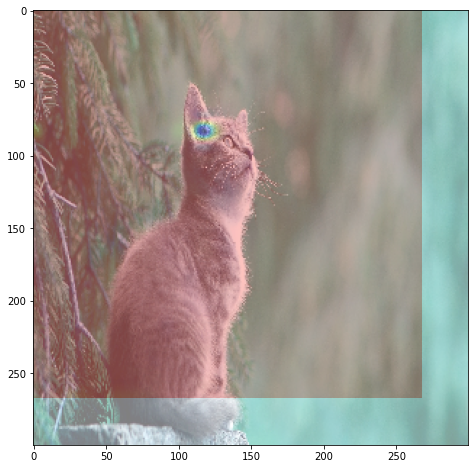

sigmoid output: [[0.01368397]]
prediction: cat


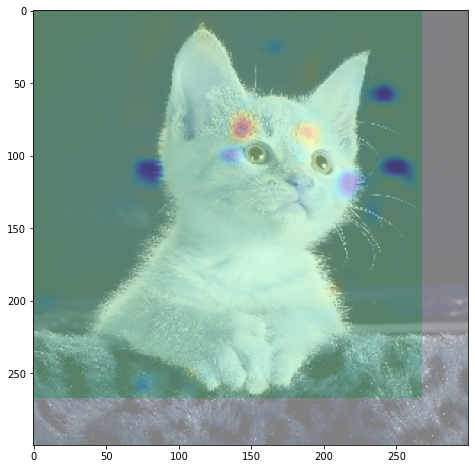

sigmoid output: [[0.5835444]]
prediction: dog


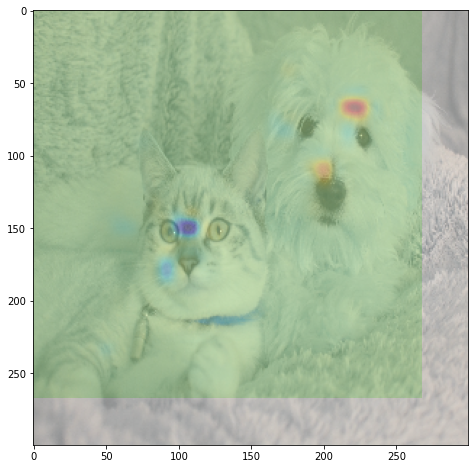

sigmoid output: [[0.9558673]]
prediction: dog


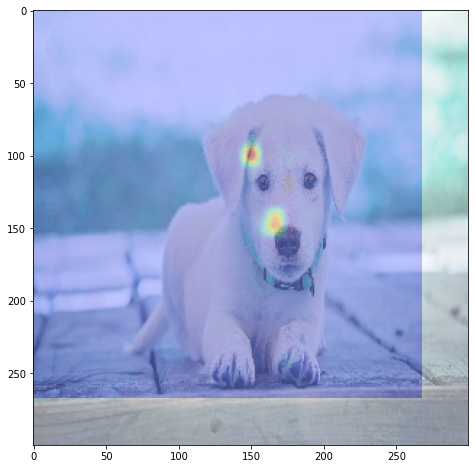

sigmoid output: [[0.10173441]]
prediction: cat


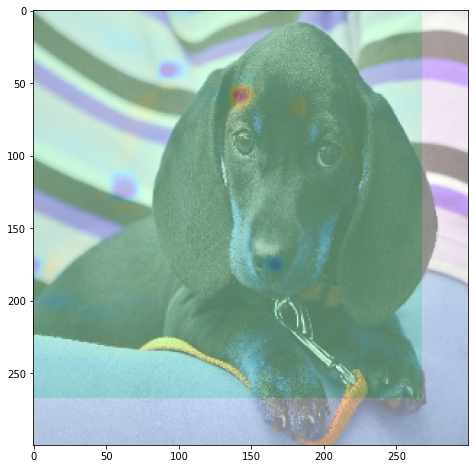

In [39]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300))
  img = img/255

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features, results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')